In [3]:
import glob
from tqdm import tqdm
from src.create_annotations import *

category_ids = {
    "Background":0,
    "General trash":1,
    "Paper":2,
    "Paper pack":3,
	"Metal":4,
	"Glass":5,
	"Plastic":6,
	"Styrofoam":7,
	"Plastic bag":8,
	"Battery":9,
	"Clothing":10
    }

category_colors = {
    "(0, 0, 0)":0,
    "(192, 0, 128)":1,
    "(0, 128, 192)":2,
    "(0, 128, 64)":3,
    "(128, 0, 0)":4,
    "(64, 0, 128)":5,
    "(64, 0, 192)":6,
    "(192, 128, 64)":7,
    "(192, 192, 128)":8,
    "(64, 64, 128)":9,
    "(128, 0, 192)":10
}

# Get "images" and "annotations" info 
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    multipolygon = []
    invalid_pixel = []
    
    for mask_image in tqdm(glob.glob(maskpath + "*.png")):
        # The mask image is *.png but the original image is *.jpg.
        # We make a reference to the original file in the COCO JSON file
        original_file_name = os.path.basename(mask_image).split(".")[0] + ".jpg"

        # Open the image and (to be sure) we convert it to RGB
        mask_image_open = Image.open(mask_image).convert("RGB")
        w, h = mask_image_open.size
        
        # "images" info 
        image = create_image_annotation(original_file_name, w, h, image_id)
        images.append(image)
        sub_masks = create_sub_masks(mask_image_open, w, h)
        for color, sub_mask in sub_masks.items():

            if color not in category_colors.keys():
                category_colors[color] = 0
                print(f'INVALID PIXEL !!!\t {original_file_name}')
                invalid_pixel.append(original_file_name)

            category_id = category_colors[color]

            # "annotations" info
            # Check Whether MultiPolygon or not
            try:
                polygons, segmentations = create_sub_mask_annotation(sub_mask)
            except:
                images.pop()
                image_id -= 1
                print(f'MULTIPOLYGON !!!\t {original_file_name}')
                multipolygon.append(original_file_name)
                break

            for i in range(len(polygons)):
                # Cleaner to recalculate this variable
                segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                
                annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                
                annotations.append(annotation)
                annotation_id += 1

        image_id += 1
        
    return images, annotations, annotation_id, multipolygon, invalid_pixel

In [4]:
# Get the standard COCO JSON format
coco_format = get_coco_json_format()

mask_path = "/opt/ml/input/data/copy_paste/output/SegmentationClass/"

# Create category section
coco_format["categories"] = create_category_annotation(category_ids)

# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt, multipolygon, invalid_pixel = images_annotations_info(mask_path)

with open("/opt/ml/input/data/copy_paste/output/output.json","w") as outfile:
    json.dump(coco_format, outfile, indent = 4)

print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))

  1%|          | 31/3271 [00:28<49:03,  1.10it/s]

MULTIPOLYGON !!!	 copy_paste_batch_02_vt_1959.jpg


  1%|          | 35/3271 [00:32<50:20,  1.07it/s]

INVALID PIXEL !!!	 copy_paste_batch_02_vt_1846.jpg


  1%|          | 37/3271 [00:34<50:15,  1.07it/s]

INVALID PIXEL !!!	 copy_paste_batch_02_vt_0478.jpg


  2%|▏         | 74/3271 [01:08<49:23,  1.08it/s]

INVALID PIXEL !!!	 copy_paste_batch_02_vt_0591.jpg


  3%|▎         | 102/3271 [01:33<50:42,  1.04it/s]

INVALID PIXEL !!!	 copy_paste_batch_02_vt_1302.jpg


  3%|▎         | 114/3271 [01:44<47:07,  1.12it/s]

MULTIPOLYGON !!!	 copy_paste_batch_02_vt_1807.jpg


  8%|▊         | 258/3271 [03:56<46:30,  1.08it/s]

INVALID PIXEL !!!	 copy_paste_batch_03_0240.jpg


 20%|██        | 663/3271 [10:11<39:50,  1.09it/s]

MULTIPOLYGON !!!	 copy_paste_batch_02_vt_0557.jpg


 40%|████      | 1314/3271 [20:10<29:54,  1.09it/s]

MULTIPOLYGON !!!	 copy_paste_batch_02_vt_0291.jpg


 42%|████▏     | 1381/3271 [21:11<28:13,  1.12it/s]

MULTIPOLYGON !!!	 copy_paste_batch_02_vt_0584.jpg


 52%|█████▏    | 1705/3271 [26:07<23:23,  1.12it/s]

MULTIPOLYGON !!!	 copy_paste_batch_02_vt_0527.jpg


 67%|██████▋   | 2176/3271 [33:18<16:18,  1.12it/s]

MULTIPOLYGON !!!	 copy_paste_batch_02_vt_1439.jpg


100%|██████████| 3271/3271 [50:01<00:00,  1.09it/s]


Created 123850 annotations for images in folder: /opt/ml/input/data/copy_paste/output/SegmentationClass/


In [5]:
multipolygon

['copy_paste_batch_02_vt_1959.jpg',
 'copy_paste_batch_02_vt_1807.jpg',
 'copy_paste_batch_02_vt_0557.jpg',
 'copy_paste_batch_02_vt_0291.jpg',
 'copy_paste_batch_02_vt_0584.jpg',
 'copy_paste_batch_02_vt_0527.jpg',
 'copy_paste_batch_02_vt_1439.jpg']

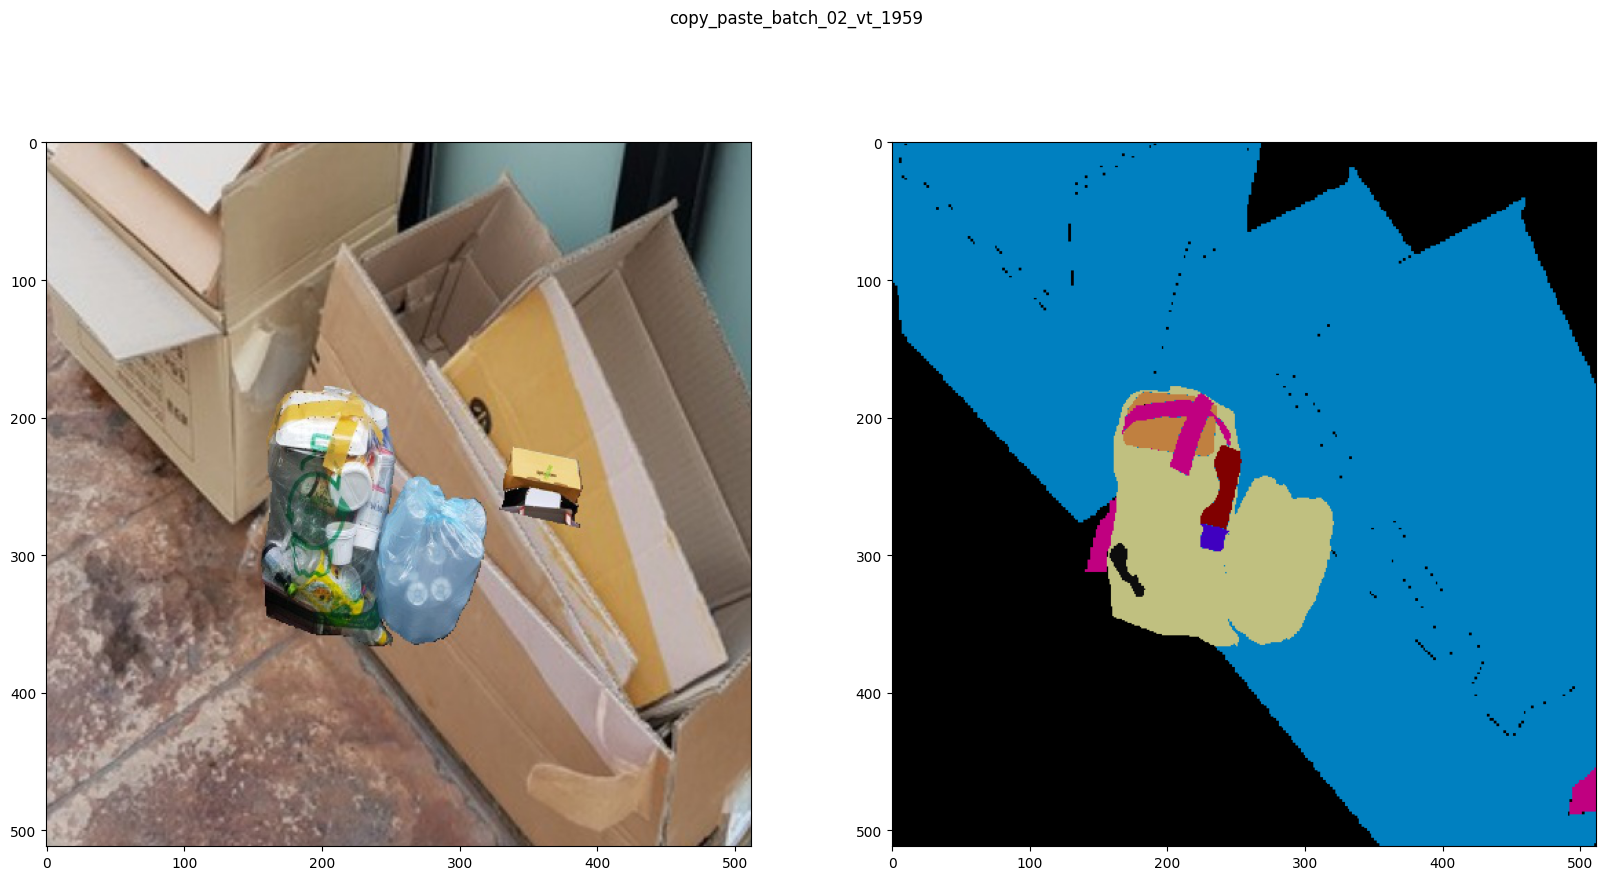

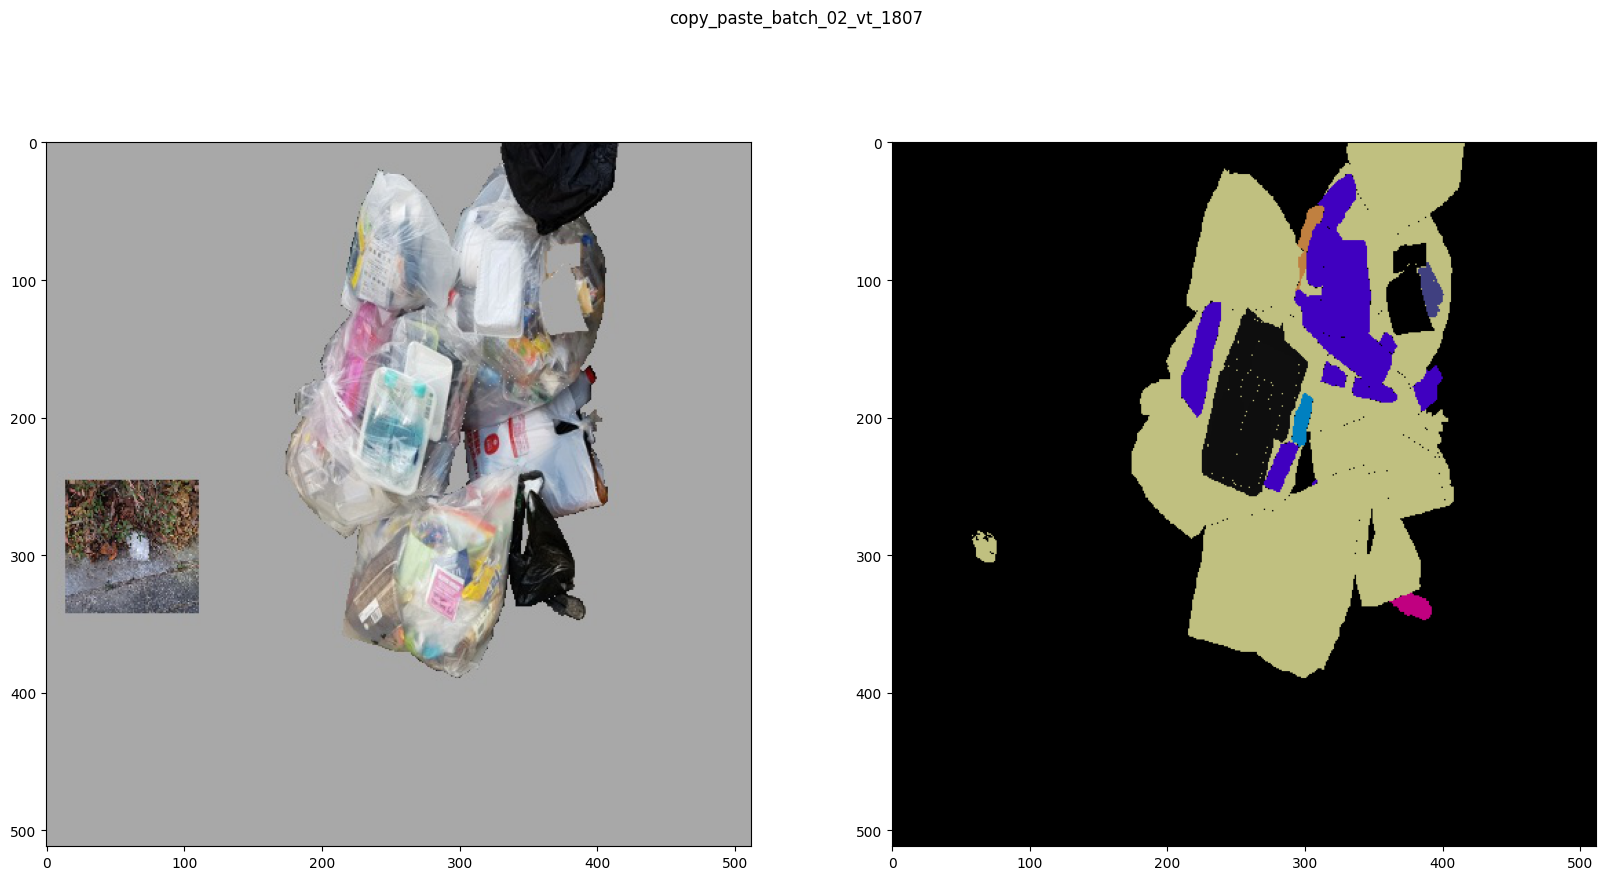

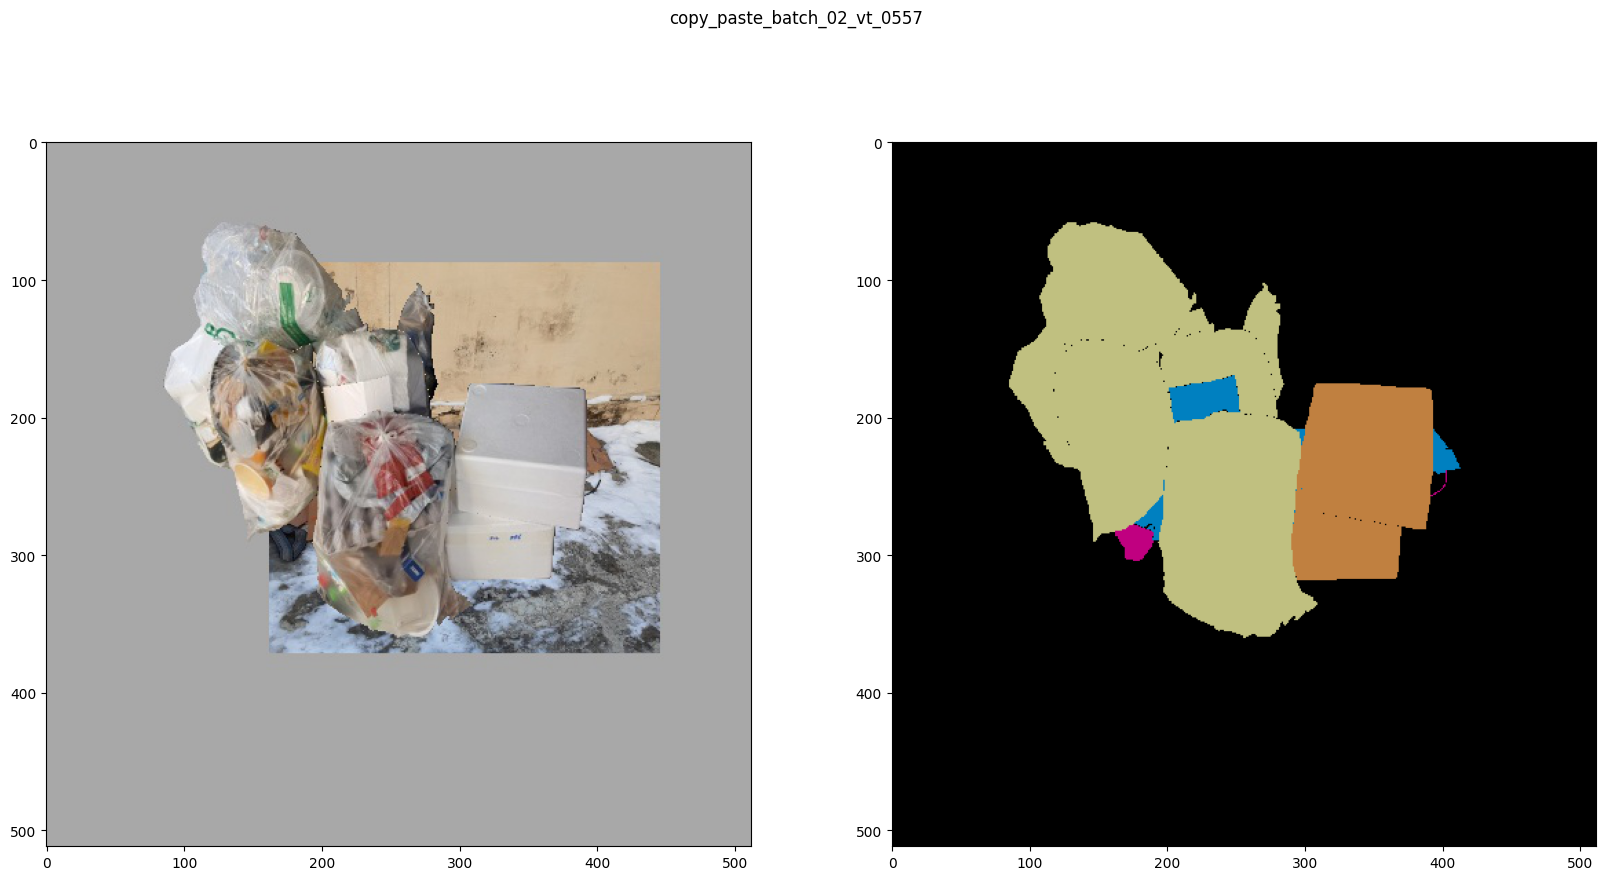

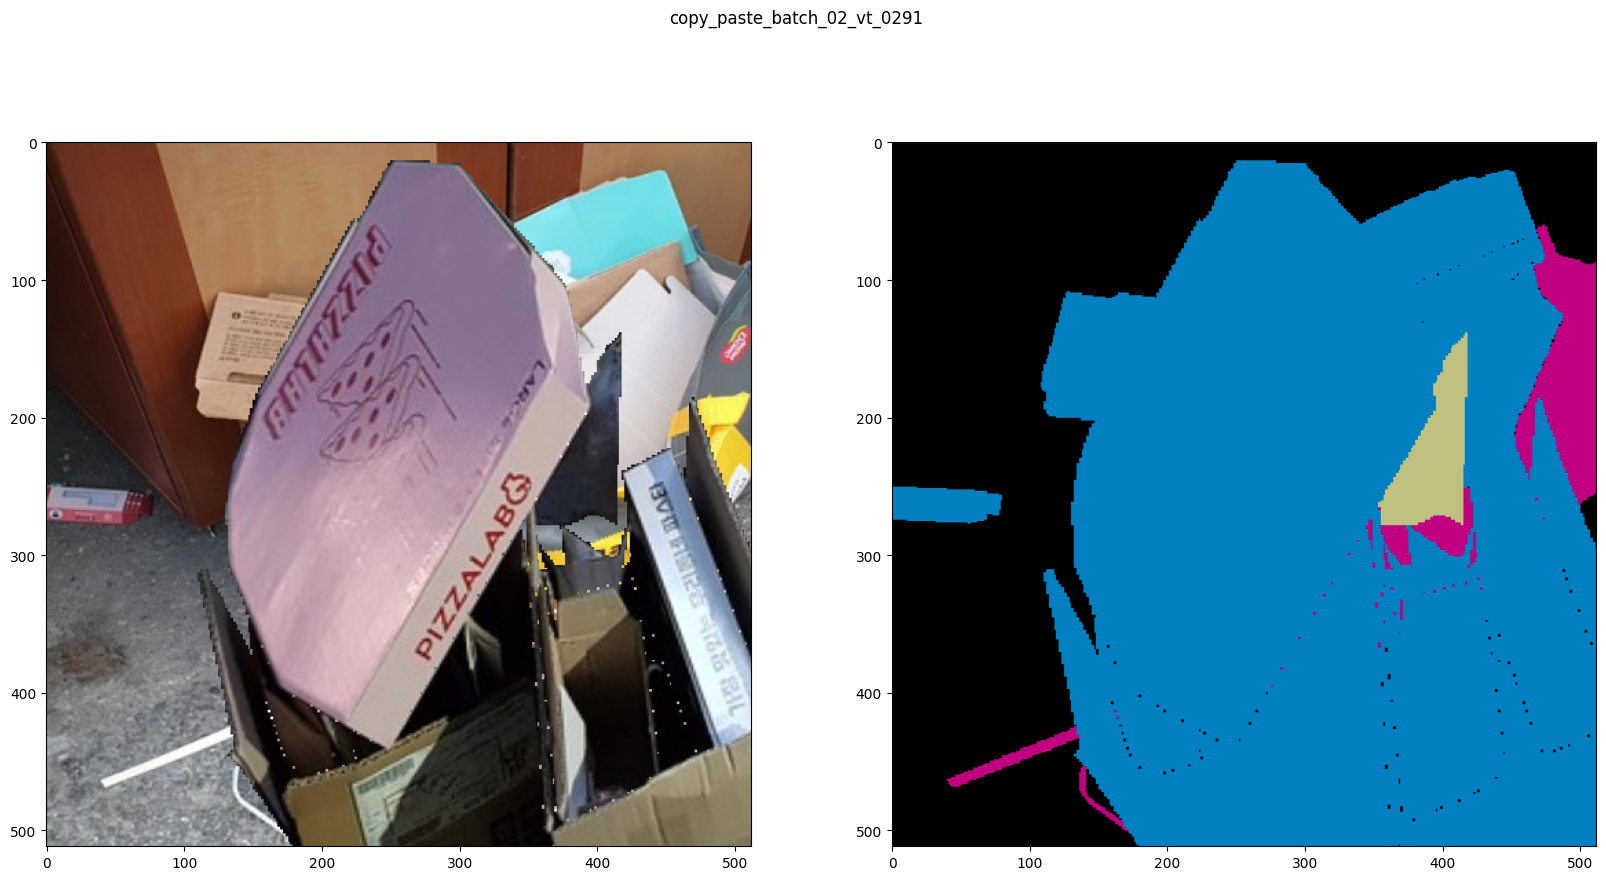

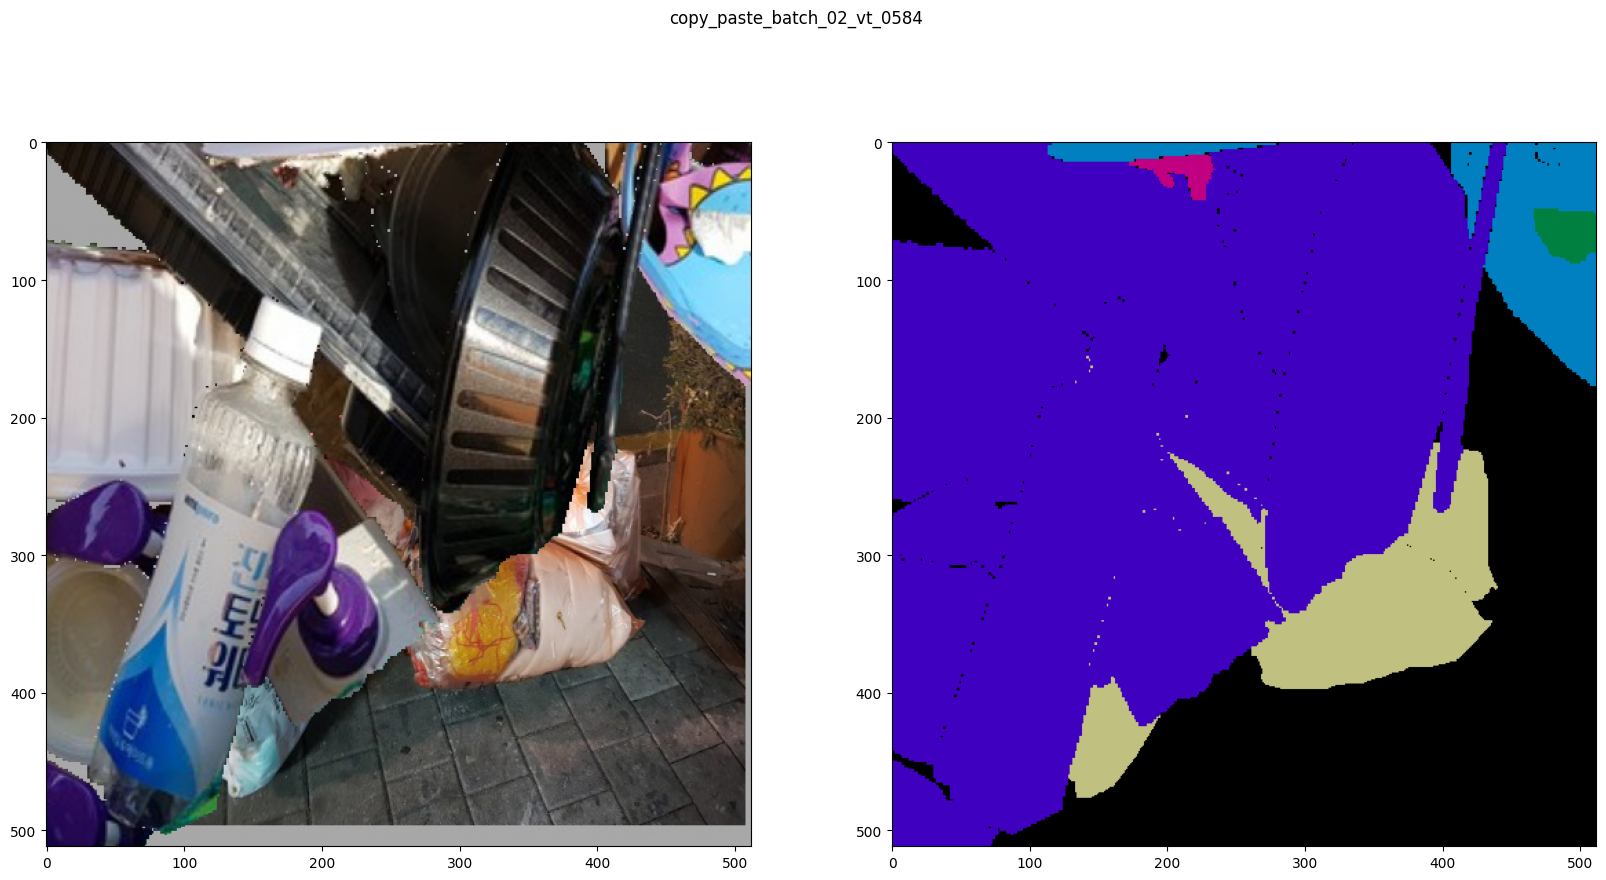

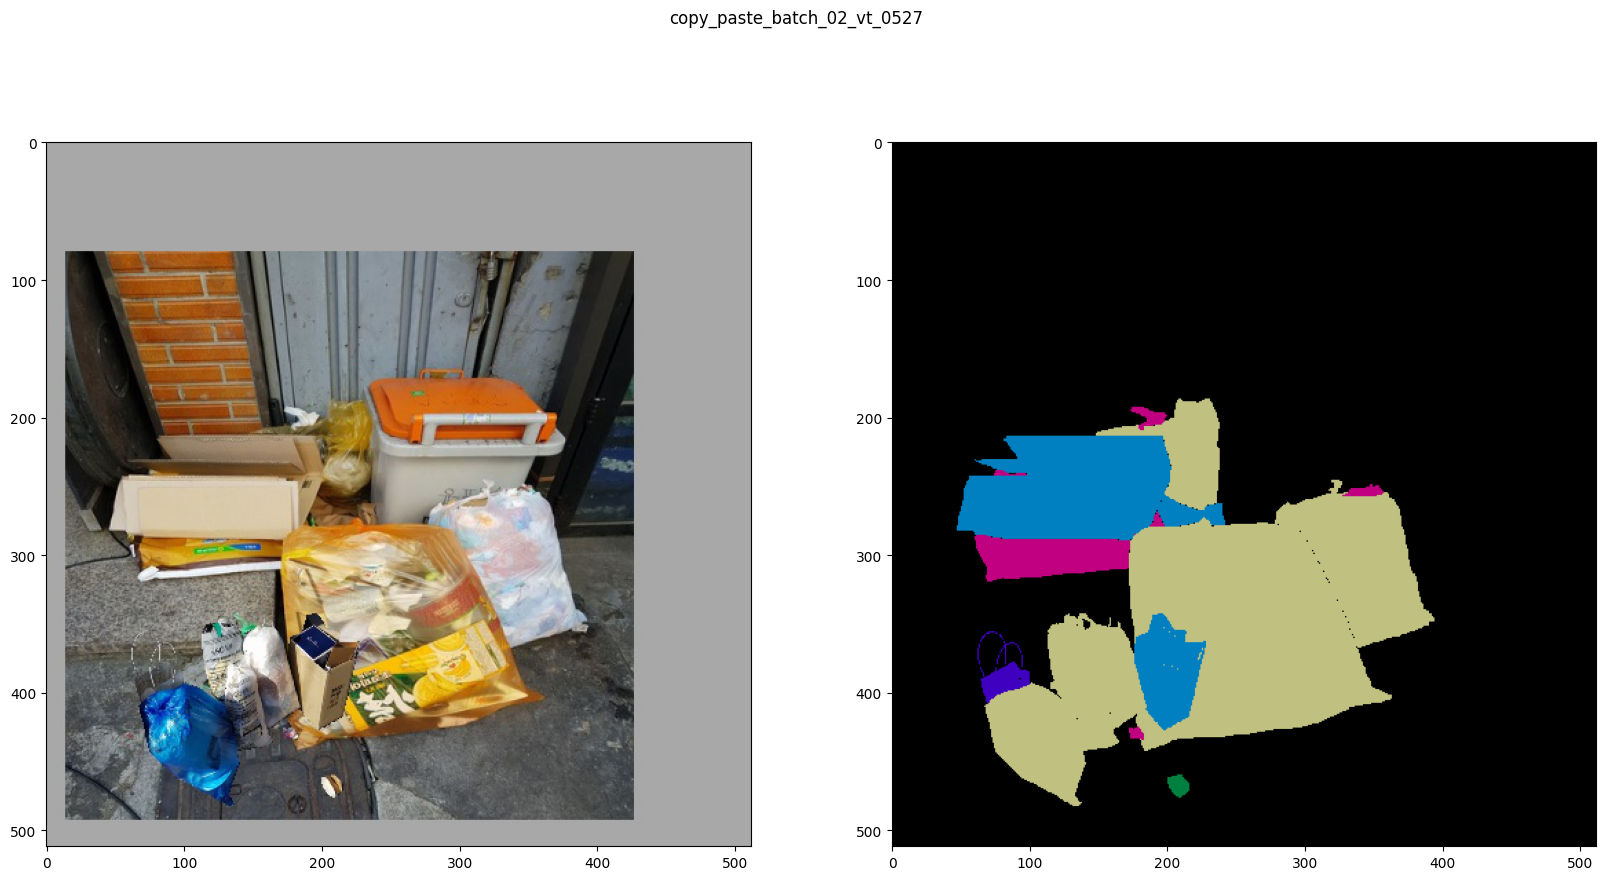

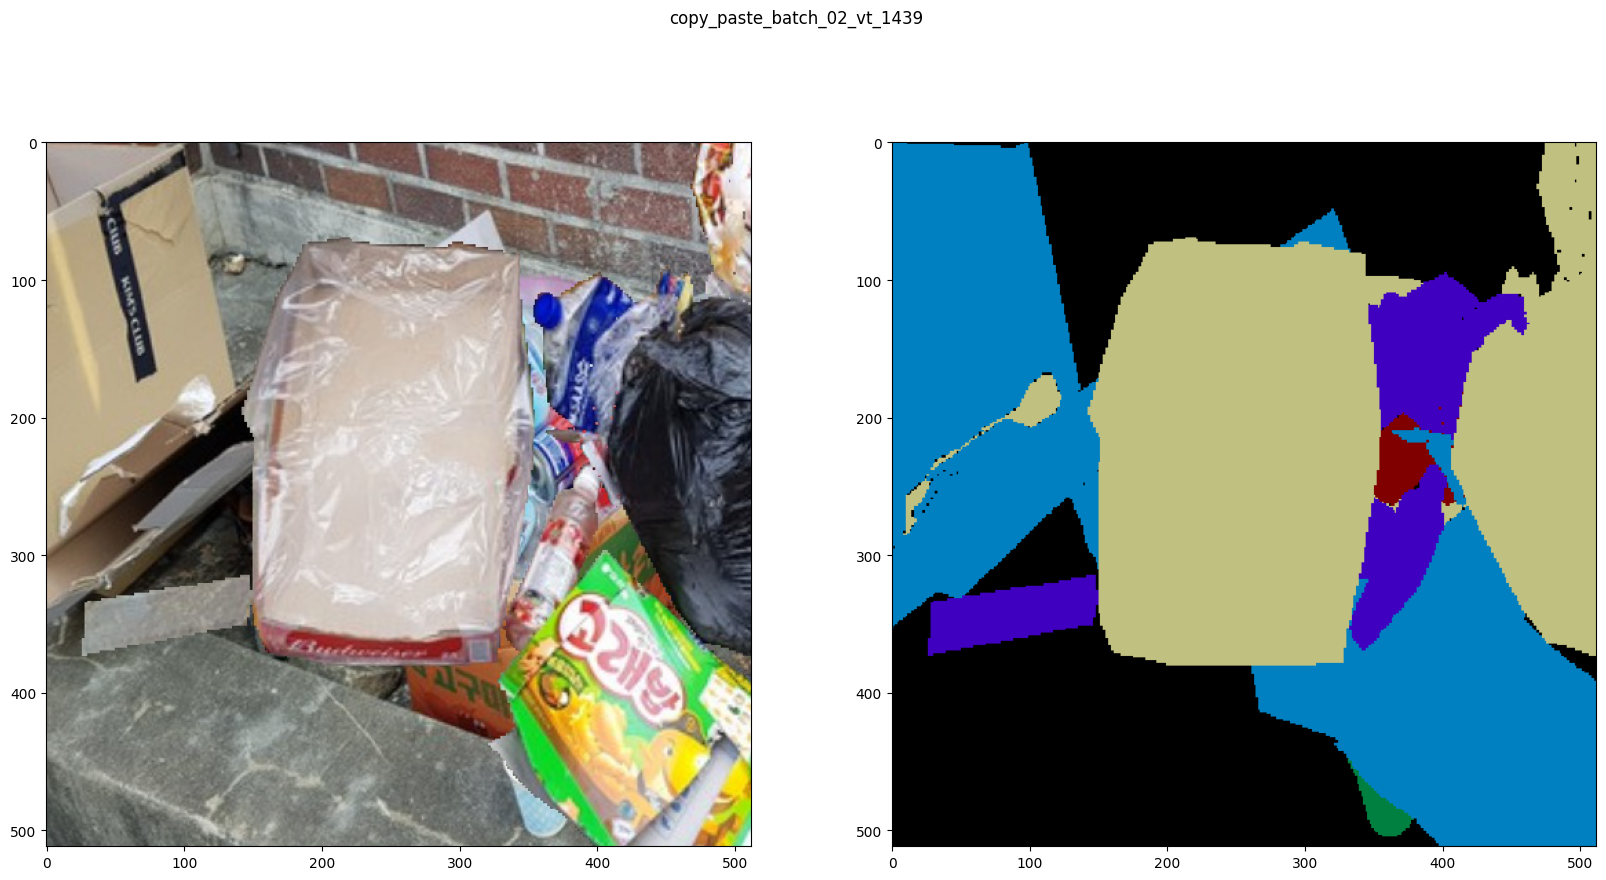

In [18]:
import matplotlib.pyplot as plt

for i in multipolygon:
    name = i.split('.')[0]
    plt.figure(figsize = (20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(f'/opt/ml/input/data/copy_paste/output/JPEGImages/{name}.jpg'))
    plt.subplot(1, 2, 2)
    plt.imshow(Image.open(f'/opt/ml/input/data/copy_paste/output/SegmentationClass/{name}.png'))
    plt.suptitle(name)
    plt.show()

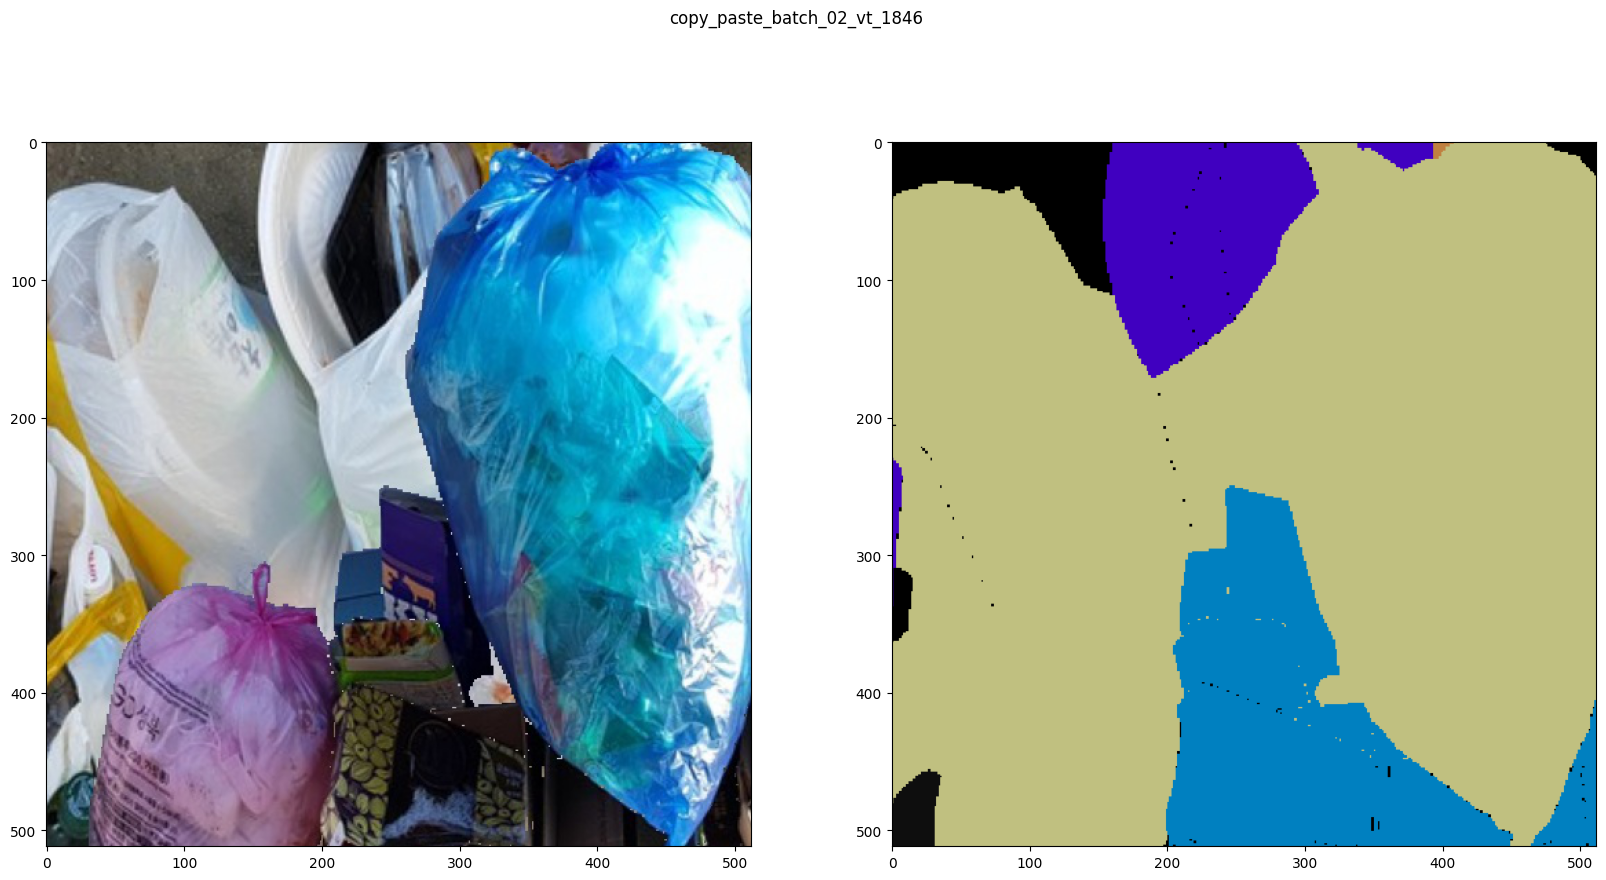

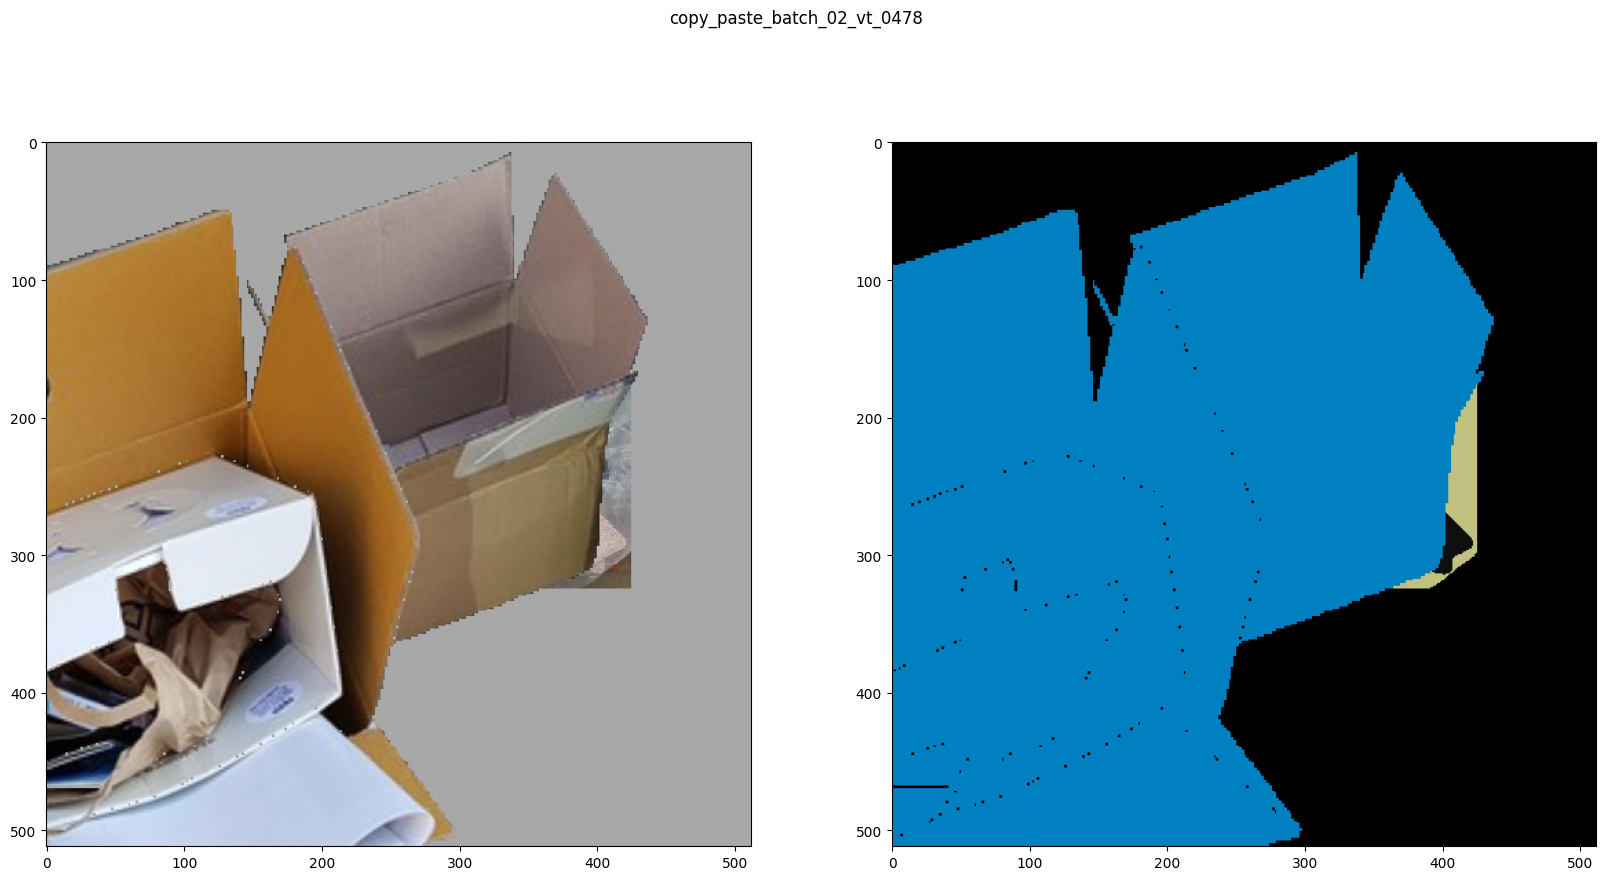

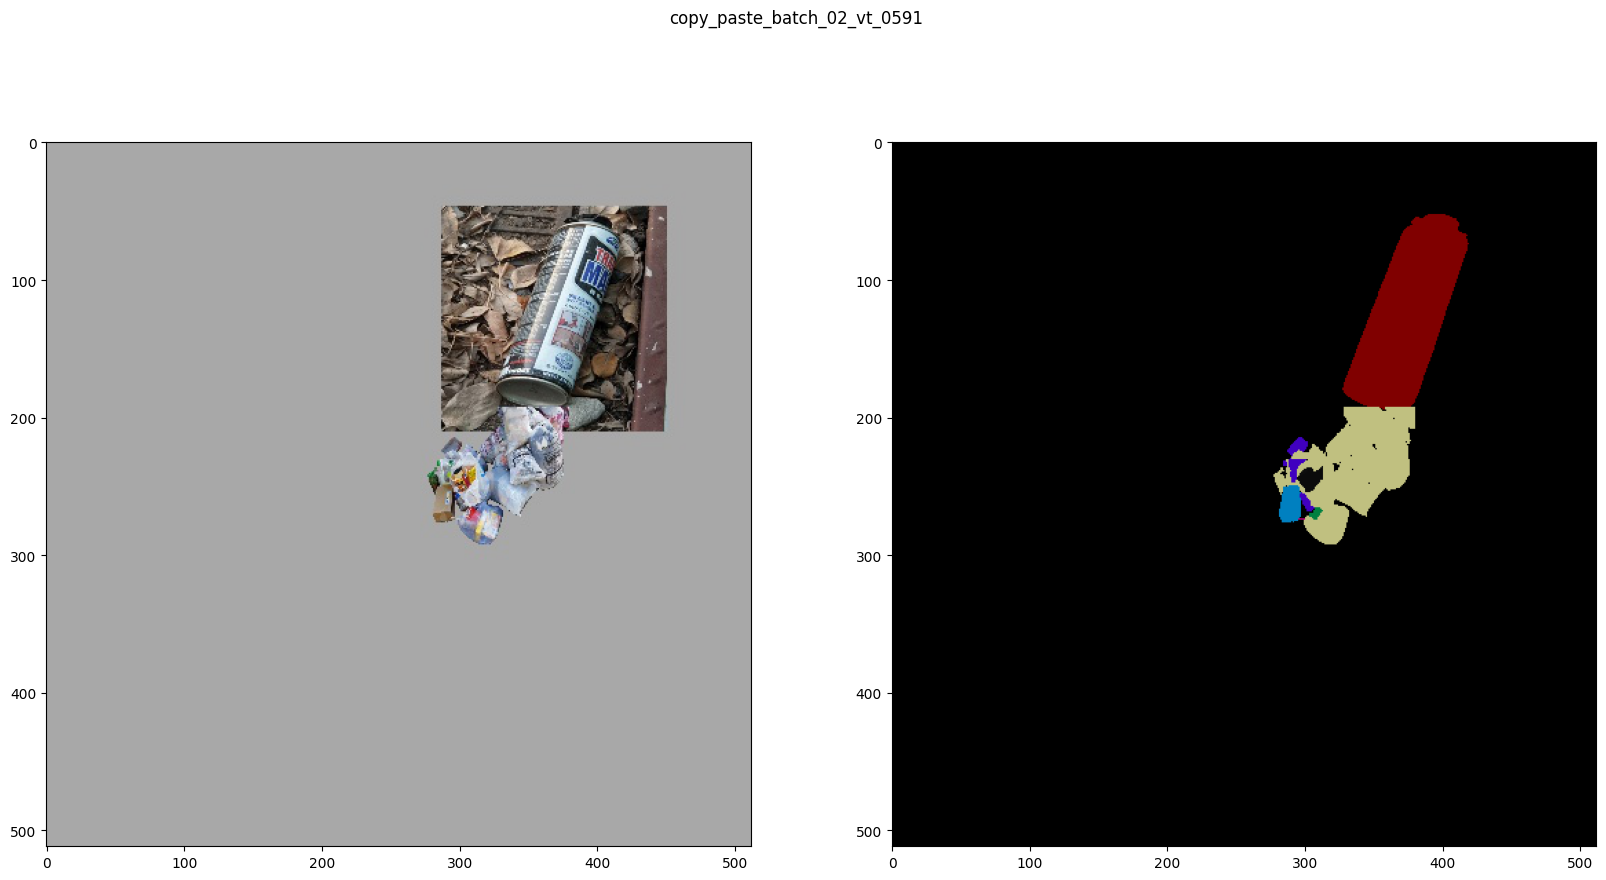

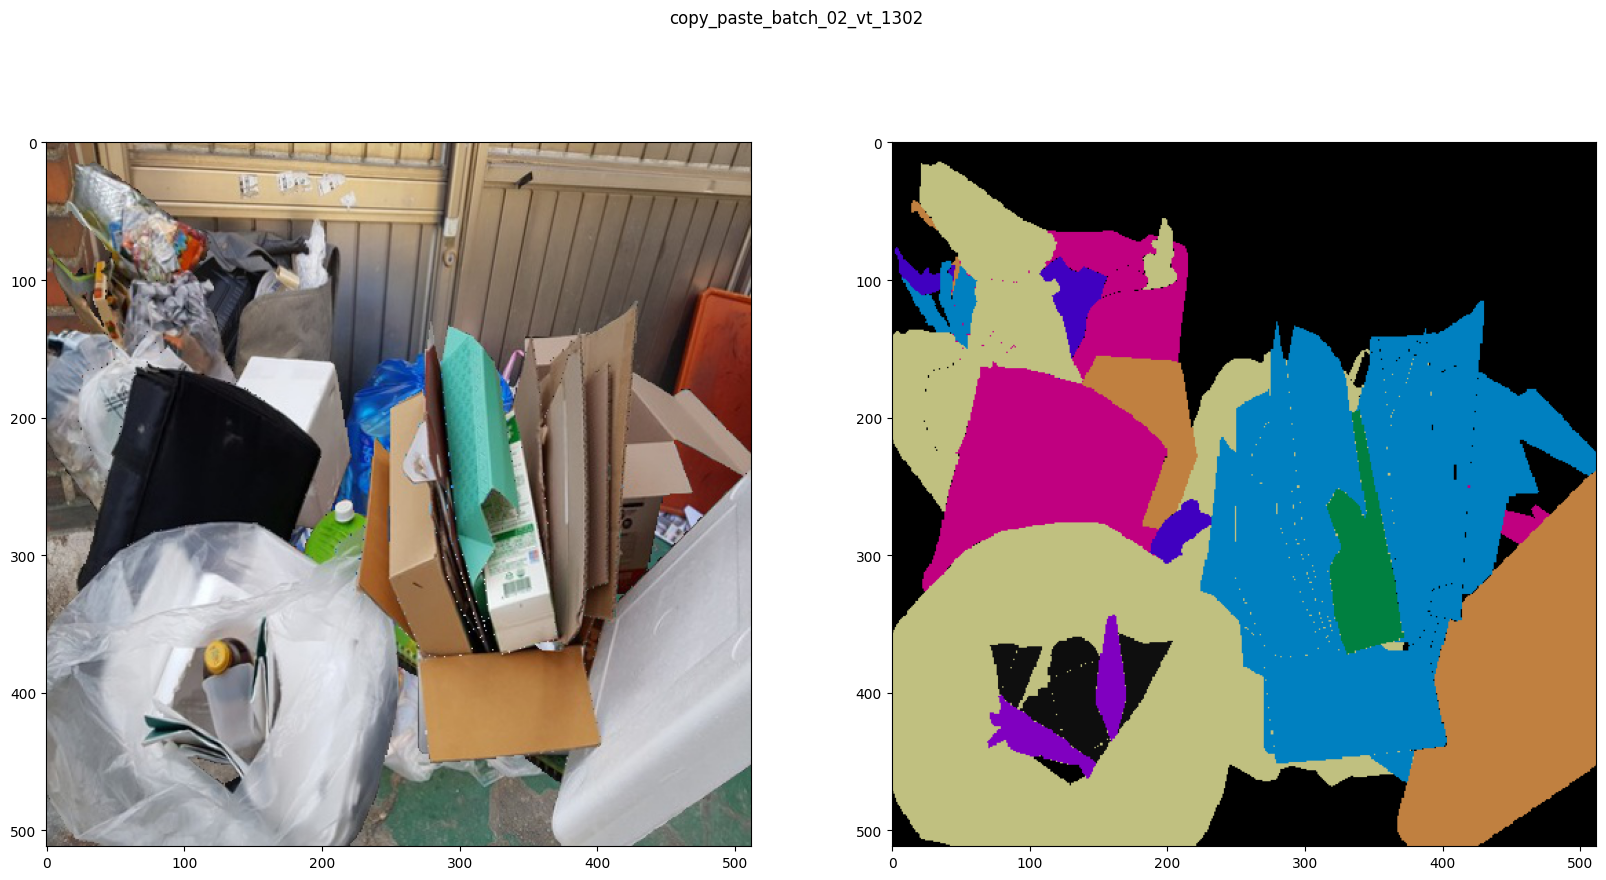

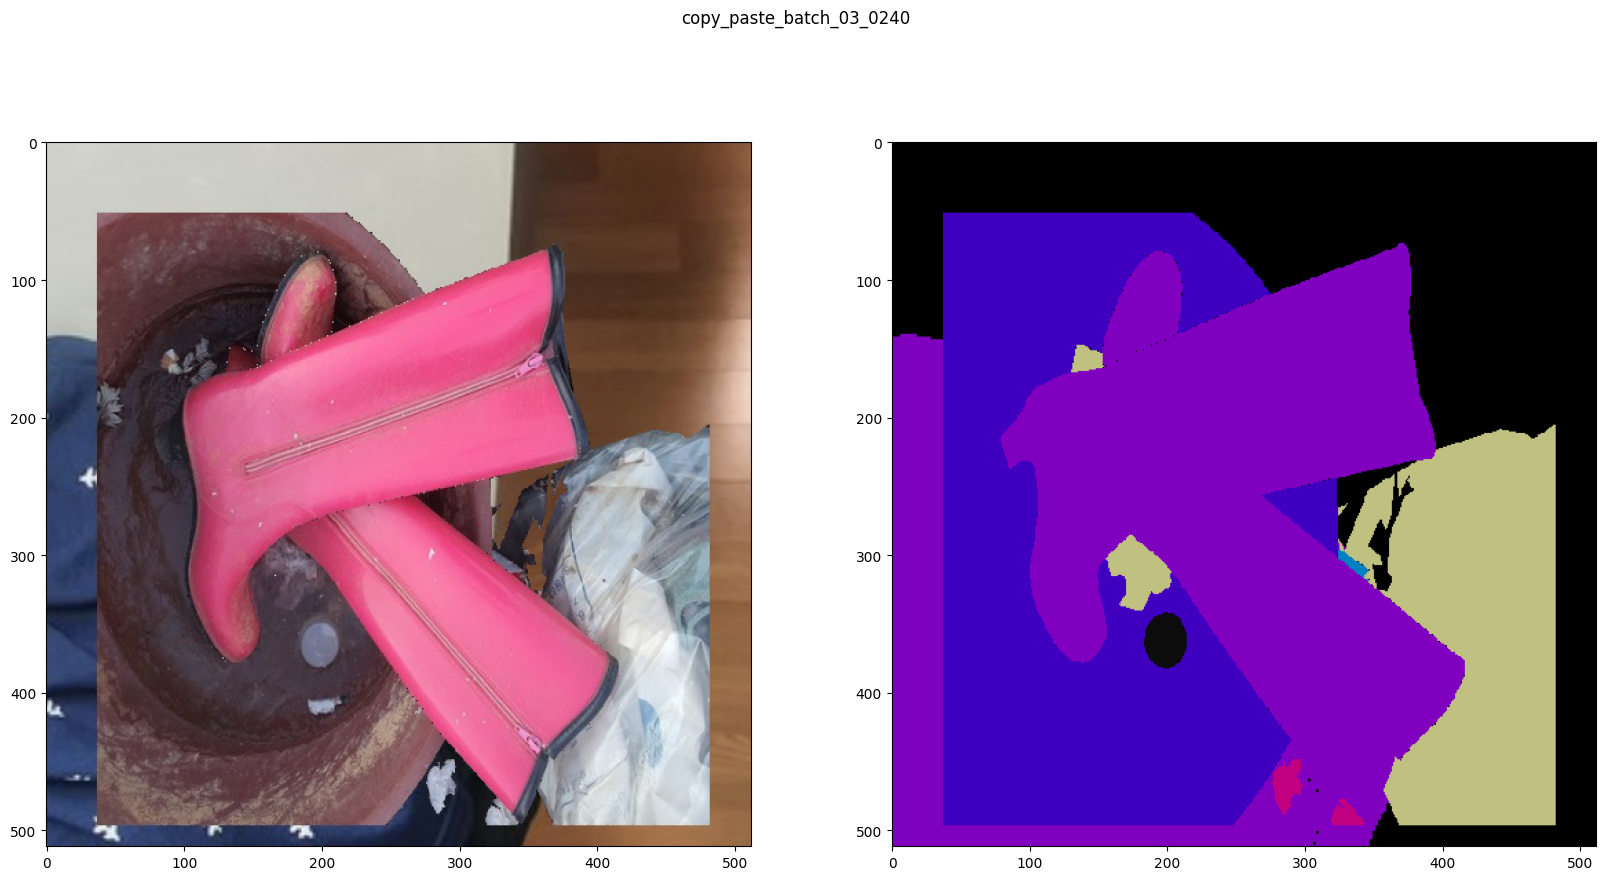

In [19]:
for i in invalid_pixel:
    name = i.split('.')[0]
    plt.figure(figsize = (20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(f'/opt/ml/input/data/copy_paste/output/JPEGImages/{name}.jpg'))
    plt.subplot(1, 2, 2)
    plt.imshow(Image.open(f'/opt/ml/input/data/copy_paste/output/SegmentationClass/{name}.png'))
    plt.suptitle(name)
    plt.show()

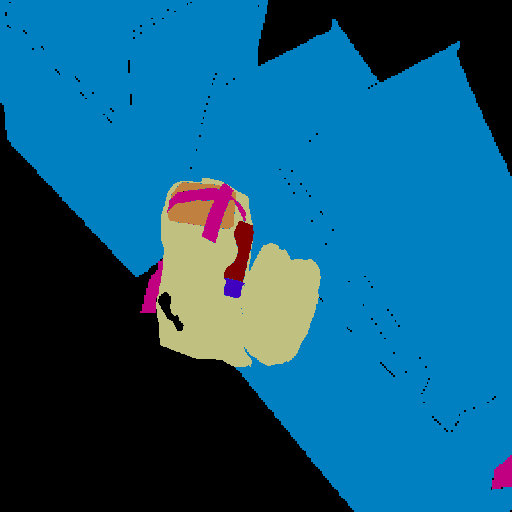

In [ ]:
a_ = Image.open('/opt/ml/input/data/copy_paste/output/JPEGImages/copy_paste_batch_02_vt_1959.jpg')
plt.imshow(a_)

In [2]:
a = Image.open('/opt/ml/input/data/copy_paste/output/SegmentationClass/copy_paste_batch_02_vt_1846.png').convert('RGB')

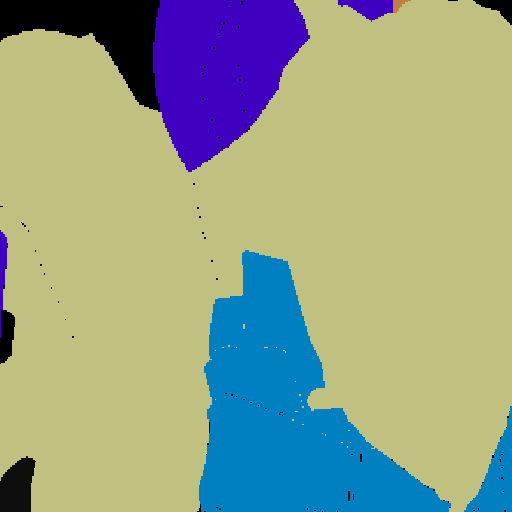

In [3]:
a